# Model Hyperparameter tunning
In this notebook the hyperparameter tunning for each model is performed and visualized

In [1]:
import os
import time
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import mean_squared_error

dataset_path = os.path.join('..','Data','Final_Dataset','final_dataset.parquet')
dataset = pl.read_parquet(dataset_path)
pollutants_cols = [col for col in dataset.columns if col.startswith('MONTHLY')]

## Feature Selection

In [2]:
feature_cols = [
        "EURO_1", "EURO_2", "EURO_3", "EURO_4", "EURO_5", "EURO_6", "EURO_CLEAN",
        "Previous","TotalFleet"]

context_cols = ["CITY_AREA","POPULATION","Population_density"]    
    
cars_per_surface = [
        "CARS_PER_KM2", "EURO_1_PER_KM2", "EURO_2_PER_KM2","EURO_3_PER_KM2","EURO_4_PER_KM2",
        "EURO_5_PER_KM2","EURO_6_PER_KM2","EURO_CLEAN_PER_KM2","Previous_PER_KM2"]
    
cars_per_capita = [
        "CARS_PER_CAPITA", "EURO_1_PER_CAPITA", "EURO_2_PER_CAPITA",
        "EURO_3_PER_CAPITA","EURO_4_PER_CAPITA","EURO_5_PER_CAPITA","EURO_6_PER_CAPITA",
        "EURO_CLEAN_PER_CAPITA","Previous_PER_CAPITA"]

blocks = {'basic' : feature_cols, 
         'context' : feature_cols+context_cols, 
         'per_capita': feature_cols+context_cols+cars_per_capita,
         'per_surface': feature_cols+context_cols+cars_per_surface,
         'complete':feature_cols+context_cols+cars_per_surface+cars_per_capita}


In [ ]:
outer_cv = KFold(5, shuffle=True, random_state=42)

blocks = {'per_capita_non_context': feature_cols+cars_per_capita,
         'per_surface_non_context': feature_cols+cars_per_surface,
         'complete_non_context':feature_cols+cars_per_surface+cars_per_capita}

dataset_path = os.path.join('..','Data','Final_Dataset','final_dataset.parquet')
results_list = []

dataset = pl.read_parquet(dataset_path)
pollutants_cols = [col for col in dataset.columns if col.startswith('MONTHLY')]
raw = dataset.to_pandas()

for pollutant_col in pollutants_cols:
    pollutant = pollutant_col.split('_')[0][7:]
    raw_aux = raw[raw[pollutant_col].notna()]
    for name, cols in blocks.items():
        print(f'Tunning the pollutant {pollutant} with the {name} block')
        X = raw_aux[cols]
        y = raw_aux[pollutant_col]

        est = LGBMRegressor(
            objective='regression',
            metric='rmse',
            random_state=42,
            n_jobs=1,
            verbosity=-1
        )
    
        param_dist = {
            'num_leaves':      sp_randint(2, 66),
            'max_depth':       sp_randint(3, 51),
            'learning_rate':   sp_uniform(0.01, 0.14),
            'n_estimators':    sp_randint(100, 601),
            'min_child_samples': sp_randint(1, 51),
            'boosting_type':   ['gbdt']
            }

        search = RandomizedSearchCV(
            est, param_dist,
            n_iter=200,
            cv=outer_cv,
            scoring='neg_root_mean_squared_error',
            random_state=1,
            n_jobs=-1,
            verbose=1
        )

        start = time.time()
        search.fit(X, y)
        
        elapsed = time.time() - start
        best_rmse = -search.best_score_
        best_params = search.best_params_
        
        results_list.append({
            'pollutant': pollutant,
            'block': name,
            'best_rmse': best_rmse,
            'best_params': best_params,
            'duration_s': elapsed
        })
        
        print(f"[{pollutant} - {name}] RMSE = {best_rmse:.5f}, elapsed time = {elapsed:.0f}s")

df_results = pd.DataFrame(results_list)
output_path = os.path.join('..','Models','Results','1st_stage2.csv')
df_results.to_csv(output_path, index=False)

Tunning the pollutant CO with the basic block
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CO - basic] RMSE = 0.08939, elapsed time = 230s
Tunning the pollutant CO with the context block
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CO - context] RMSE = 0.08948, elapsed time = 245s
Tunning the pollutant CO with the per_capita block
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CO - per_capita] RMSE = 0.08744, elapsed time = 412s
Tunning the pollutant CO with the per_surface block
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CO - per_surface] RMSE = 0.08901, elapsed time = 389s
Tunning the pollutant CO with the complete block
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CO - complete] RMSE = 0.08778, elapsed time = 554s
Tunning the pollutant NO2 with the basic block
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[NO2 - basic] RMSE = 4.69630, elapsed time = 206s
Tunning the 

In [ ]:
output_path = os.path.join('..','Models','Results','1st_stage2.csv')
feature_selections = pl.read_csv(output_path)

/var/folders/gk/9s2n71rj4fq128zrj3x599pr0000gn/T/ipykernel_10348/2199796160.py:15: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  scored.pivot(values="score", index="pollutant", columns="block").sort("pollutant")


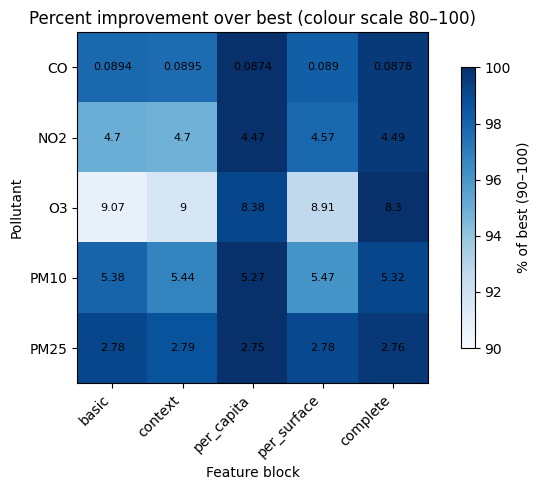

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

scored = (
    feature_selections.with_columns(
        (100 * (1 - (pl.col("best_rmse") - pl.col("best_rmse").min().over("pollutant"))
                         / pl.col("best_rmse").min().over("pollutant")))
        .alias("score")
    )
)

heat = (
    scored.pivot(values="score", index="pollutant", columns="block").sort("pollutant")
)

matrix = heat.drop("pollutant").to_numpy()

vmin, vmax = 90, 100
cmap = plt.get_cmap("Blues").copy()
cmap.set_under("lightgrey")
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(matrix.shape[1]*1.4,
                                matrix.shape[0]*0.6 + 2))
im = ax.imshow(matrix, cmap=cmap, norm=norm)

ax.set_xticks(np.arange(matrix.shape[1]),
              labels=heat.columns[1:], rotation=45, ha="right")
ax.set_yticks(np.arange(matrix.shape[0]),
              labels=heat["pollutant"])
ax.set_xlabel("Feature block")
ax.set_ylabel("Pollutant")
ax.set_title("Percent improvement over best (colour scale 80–100)")

for i, pollutant in enumerate(heat["pollutant"]):
    for j, block in enumerate(heat.columns[1:]):
        rmse = (
            feature_selections
            .filter((pl.col("pollutant") == pollutant) &
                    (pl.col("block") == block))
            .select("best_rmse")
            .item()
        )
        ax.text(j, i, f"{rmse:.3g}", ha="center", va="center",
                color="black", fontsize=8)

fig.colorbar(im, ax=ax, shrink=0.8, label="% of best (90–100)")
plt.tight_layout()
output_path = os.path.join('..','Figures','Model_feature_selec.png')
plt.savefig(output_path)
plt.show()


## Hyperparameter tunning

In [40]:
feature_selections.filter(pl.col('block') == 'per_capita')['best_params'].to_list()
pollutants = feature_selections['pollutant'].unique().to_list()
for pollutant in pollutants:
    params = feature_selections.filter((pl.col('pollutant') == pollutant) &
                                 (pl.col('block') == 'per_capita'))['best_params'].item()
    print(f'For the pollutant {pollutant} the best parameters where:')
    print(f'{params}')

For the pollutant CO the best parameters where:
{'boosting_type': 'gbdt', 'learning_rate': np.float64(0.09908068544826885), 'max_depth': 32, 'min_child_samples': 12, 'n_estimators': 545, 'num_leaves': 61}
For the pollutant O3 the best parameters where:
{'boosting_type': 'gbdt', 'learning_rate': np.float64(0.1148499725344171), 'max_depth': 42, 'min_child_samples': 4, 'n_estimators': 541, 'num_leaves': 45}
For the pollutant NO2 the best parameters where:
{'boosting_type': 'gbdt', 'learning_rate': np.float64(0.09912461600026562), 'max_depth': 42, 'min_child_samples': 7, 'n_estimators': 576, 'num_leaves': 54}
For the pollutant PM10 the best parameters where:
{'boosting_type': 'gbdt', 'learning_rate': np.float64(0.03607642959287393), 'max_depth': 48, 'min_child_samples': 7, 'n_estimators': 381, 'num_leaves': 52}
For the pollutant PM25 the best parameters where:
{'boosting_type': 'gbdt', 'learning_rate': np.float64(0.09952452332319162), 'max_depth': 19, 'min_child_samples': 20, 'n_estimators

In [42]:
dataset_path = os.path.join('..','Data','Final_Dataset','final_dataset.parquet')
dataset = pl.read_parquet(dataset_path)
pol_cols = ['MONTHLYNO2_concentration','MONTHLYO3_concentration','MONTHLYPM10_concentration','MONTHLYPM25_concentration']
for col in pollutants_cols:
    print(col)
    mean = dataset[col].mean()
    print(mean)

MONTHLYCO_concentration
0.32460047247642565
MONTHLYNO2_concentration
22.31513818594334
MONTHLYO3_concentration
48.63834811887307
MONTHLYPM10_concentration
21.055471479084474
MONTHLYPM25_concentration
10.428956984137121


In [ ]:
outer_cv = KFold(5, shuffle=True, random_state=42)

dataset_path = os.path.join('..','Data','Final_Dataset','final_dataset.parquet')
results_list = []

dataset = pl.read_parquet(dataset_path)
pollutants_cols = [col for col in dataset.columns if col.startswith('MONTHLY')]
raw = dataset.to_pandas()

param_dist = {
    'num_leaves':      sp_randint(42, 66),
    'max_depth':       sp_randint(15, 51),
    'learning_rate':   sp_uniform(0.03, 0.14),
    'n_estimators':    sp_randint(350, 601),
    'min_child_samples': sp_randint(1, 26),
    'boosting_type':   ['gbdt']
    }

cols = [
        "EURO_1", "EURO_2", "EURO_3", "EURO_4", "EURO_5", "EURO_6", "EURO_CLEAN",
        "Previous","TotalFleet","CITY_AREA","POPULATION","Population_density",
        "CARS_PER_CAPITA", "EURO_1_PER_CAPITA", "EURO_2_PER_CAPITA",
        "EURO_3_PER_CAPITA","EURO_4_PER_CAPITA","EURO_5_PER_CAPITA","EURO_6_PER_CAPITA",
        "EURO_CLEAN_PER_CAPITA","Previous_PER_CAPITA"]

for pollutant_col in pollutants_cols:
    pollutant = pollutant_col.split('_')[0][7:]
    raw_aux = raw[raw[pollutant_col].notna()]
    print(f'Tunning the pollutant {pollutant} with the {name} block')
    X = raw_aux[cols]
    y = raw_aux[pollutant_col]

    est = LGBMRegressor(
        objective='regression',
        metric='rmse',
        random_state=42,
        n_jobs=1,
        verbosity=-1
    )
    
    param_dist = param_dist

    search = RandomizedSearchCV(
        est, param_dist,
        n_iter=500,
        cv=outer_cv,
        scoring='neg_root_mean_squared_error',
        random_state=1,
        n_jobs=-1,
        verbose=1
        )

    start = time.time()
    search.fit(X, y)
        
    elapsed = time.time() - start
    best_rmse = -search.best_score_
    best_params = search.best_params_
        
    results_list.append({
        'pollutant': pollutant,
        'best_rmse': best_rmse,
        'best_params': best_params,
        'duration_s': elapsed
    })
    
    print(f"[{pollutant}] RMSE = {best_rmse:.5f}, elapsed time = {elapsed:.0f}s")

df_results = pd.DataFrame(results_list)
output_path = os.path.join('..','Models','Results','2nd_stage.csv')
df_results.to_csv(output_path, index=False)

The model employed is **LightGBM**.  
In LightGBM models, the hyper-parameters with the greatest influence are:

- `num_leaves` – upper limit on the number of terminal leaves per tree; controls overall model complexity.  
- `max_depth` – maximum depth of each tree; prevents overly deep, over-fitted trees.  
- `min_data_in_leaf` – minimum number of samples required in every leaf; higher values smooth out noisy splits.  
- `learning_rate` – weight applied to each new tree; lower rates typically generalise better but require more trees.  
- `num_iterations` – total number of boosting rounds (trees) to train.  
- `boosting_type` – boosting variant that determines how new trees are added.  
- `feature_fraction` – fraction of features randomly selected for each tree; reduces correlation among trees.  
- `bagging_fraction` – fraction of rows (samples) randomly selected for each tree when bagging is enabled.  
- `bagging_freq` – frequency, in boosting rounds, at which row bagging is applied.

Because proper tuning is critical, the following three-stage procedure will be applied for each pollutant-specific model:

1. **Stage 1**  
   Run a **Grid-Search Cross-Validation (GSCV)** over a wide grid covering all hyper-parameters listed above.

2. **Stage 2**  
   Plot validation RMSE while varying *one* hyper-parameter at a time, keeping the others at their Stage 1 best values, to locate the most promising region for each parameter.

3. **Stage 3**  
   Build a *narrow* grid centred on the preferred values identified in Stage 2 and run a second GSCV to pinpoint the joint optimum.

> **Why two grid searches instead of tuning one parameter at a time?**  
> Although inspecting parameters individually is informative, the optimal value of any hyper-parameter depends on its combination with the rest. The refined grid in Stage 3 re-evaluates combinations, ensuring RMSE is minimised while accounting for all interactions.

Grid-Search CV is chosen over Randomised-Search CV because LightGBM trains quickly on our dataset; exhaustive enumeration is feasible and provides full coverage. For more computationally demanding models, Randomised-Search or Bayesian optimisation would be preferable.

## 1st stage

In [ ]:
for i,pollutant_col in enumerate(pollutants_cols):
    pollutant = pollutant_col.split('_')[0][7:]
    print(f'HYperparameter tunning for {pollutant} model')
    start_time = time.time()
    exclude = set(pollutants_cols)
    cols_of_interest = [s for s in dataset.columns if s not in exclude]
    cols_of_interest.append(pollutant_col)

    dataset_aux = dataset.select(cols_of_interest)
    dataset_aux = dataset_aux.filter(pl.col(pollutant_col).is_not_null()).to_pandas()
    target_col = pollutant_col
    
    feature_cols = [
        "EURO_1", "EURO_2", "EURO_3", "EURO_4", "EURO_5", "EURO_6", "EURO_CLEAN",
        "Previous","CITY_AREA"]

    dataset_aux = dataset_aux.dropna(subset=feature_cols + [target_col])
    X = dataset_aux[feature_cols]
    y = dataset_aux[target_col]
        
    est = LGBMRegressor(
        objective='regression',
        metric='rmse',
        verbosity=-1,
        silent=True
        )
    
    param_grid = {'num_leaves': [2, 5, 10, 20, 40, 60],
                  'max_depth': [-1, 5, 10, 15, 25, 50],
                  'min_child_samples': [1, 10, 20, 40],
                  'learning_rate': [0.01, 0.05, 0.1],
                  'n_estimators': [100, 300, 600],
                  'boosting_type': ['gbdt'],}
    
    grid = RandomizedSearchCV(
        est, param_grid,scoring='neg_root_mean_squared_error',
        cv=5,n_jobs=-1,verbose=1,return_train_score=True,
        n_iter=200
        )

    grid.fit(X, y)

    df = pd.DataFrame(grid.cv_results_)
    df_path = os.path.join('..','Models','Results','1st_stage_'+pollutant)
    df.to_csv(df_path,sep = '|')
    print(f'Results of {pollutant} in {time.time() - start_time}')
    print("Best params:", grid.best_params_)

HYperparameter tunning for CO model
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Results of CO in 696.6560249328613
Best params: {'num_leaves': 2, 'n_estimators': 100, 'min_child_samples': 1, 'max_depth': 50, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}
HYperparameter tunning for NO2 model
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Results of NO2 in 638.2506990432739
Best params: {'num_leaves': 20, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': 50, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}
HYperparameter tunning for O3 model
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Results of O3 in 372.3169741630554
Best params: {'num_leaves': 2, 'n_estimators': 300, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}
HYperparameter tunning for PM10 model
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Results of PM10 in 540.1188971996307
Best params: {'num_leaves': 

## 2nd Stage

In [ ]:
def tune_and_collect(X,y,param_grid,target_param,cv: 5,random_state:42,):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

    estimator = LGBMRegressor(
        objective='regression',
        metric='rmse',
        verbosity=-1,
        random_state=random_state
    )

    gs = GridSearchCV(
        estimator,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_tr, y_tr)

    results = pd.DataFrame(gs.cv_results_)
    results['mean_rmse'] = -results['mean_test_score']

    param_col = f'param_{target_param}'
    keep = results[[param_col, 'mean_rmse']].sort_values(by=param_col)

    param_values = keep[param_col].tolist()
    mean_rmse    = keep['mean_rmse'].tolist()

    return param_values, mean_rmse

## 3rd Stage

In [4]:
dataset_path = os.path.join('..','Data','Final_Dataset','dataset_Ni.parquet')
dataset = pl.read_parquet(dataset_path).to_pandas()
dataset["CITY"] = dataset["CITY"].astype("category")
target_col = pollutant_cols[0]
    
feature_cols = [
    "EURO_1", "EURO_2", "EURO_3", "EURO_4", "EURO_5", "EURO_6", "EURO_CLEAN",
    "Previous","CITY_AREA"]

dataset = dataset.dropna(subset=feature_cols + [target_col])
X = dataset[feature_cols]
y = dataset[target_col]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=feature_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
est = LGBMRegressor(
    objective='regression',
    metric='rmse',
    verbosity=-1,
    silent=True
    )

param_grid = {
    'num_leaves': [2, 5, 10, 20, 40, 60],
    'max_depth': [-1, 5, 10, 15, 25, 50],
    'min_child_samples': [1, 5, 10, 20, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 600, 1000, 1500],
    'boosting_type': ['gbdt', 'dart'],
}

grid = GridSearchCV(
    est, param_grid,scoring='neg_root_mean_squared_error',
    cv=5,n_jobs=-1,verbose=1,return_train_score=True
    )

grid.fit(X_train, y_train)

df = pd.DataFrame(grid.cv_results_)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


KeyboardInterrupt: 

In [ ]:
dataset_path = os.path.join('..','Data','Final_Dataset','dataset_PM10.parquet')
dataset = pl.read_parquet(dataset_path).to_pandas()
dataset["CITY"] = dataset["CITY"].astype("category")
target_col = pollutant_cols[1]
    
feature_cols = [
    "EURO_1", "EURO_2", "EURO_3", "EURO_4", "EURO_5", "EURO_6", "EURO_CLEAN",
    "Previous","CITY_AREA"]

dataset = dataset.dropna(subset=feature_cols + [target_col])
X = dataset[feature_cols]
y = dataset[target_col]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=feature_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
est = LGBMRegressor(
    objective='regression',
    metric='rmse',
    verbosity=-1,
    silent=True
    )

param_grid = {
    'num_leaves': [2, 5, 10, 20, 40, 60],
    'max_depth': [-1, 5, 10, 15, 25, 50],
    'min_child_samples': [1, 5, 10, 20, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 600, 1000, 1500],
    'boosting_type': ['gbdt', 'dart'],
}

grid = GridSearchCV(
    est, param_grid,scoring='neg_root_mean_squared_error',
    cv=5,n_jobs=-1,verbose=1,return_train_score=True
    )

grid.fit(X_train, y_train)

df = pd.DataFrame(grid.cv_results_)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)